In [144]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import os
import warnings

# Load dữ liệu

In [145]:
Data = pd.read_excel("Data__clean.xlsm")
Data_Master = pd.read_excel("Data__clean.xlsm", sheet_name="Data_Master")

Product_Master = Data_Master.iloc[0:37,0:17]
Product_Master = Product_Master.rename(columns = Product_Master.iloc[0])
Product_Master = Product_Master[1:]

Packaging_Master = Data_Master.iloc[39:50, 0:5]
Packaging_Master = Packaging_Master.rename(columns = Packaging_Master.iloc[0])
Packaging_Master = Packaging_Master.fillna(method = 'ffill')
Packaging_Master = Packaging_Master[1:]

Facility_Master = Data_Master.iloc[52:59, 0:11]
Facility_Master = Facility_Master.rename(columns = Facility_Master.iloc[0])
Facility_Master = Facility_Master[1:]

Collection_Point_Capacity = Data_Master.iloc[61:65, 0:6]
Collection_Point_Capacity = Collection_Point_Capacity.rename(columns = Collection_Point_Capacity.iloc[0])
Collection_Point_Capacity = Collection_Point_Capacity[1:]
Collection_Point_Capacity = Collection_Point_Capacity.fillna(method = 'ffill')

Customer_Master = pd.read_excel("Data__clean.xlsm", sheet_name="Customer_Master")

Sales_Order = pd.read_excel("Data__clean.xlsm", sheet_name="Sales_Order")

# Khởi tạo dataframe cho các dữ liệu cần

In [146]:
Data_to_Use = pd.DataFrame()
Data_to_Use['ProductID'] = Sales_Order['ProductID']
Data_to_Use['CustomerRef'] = Sales_Order['CustomerRef']
Data_to_Use['SOCreationDate'] = Sales_Order['SOCreationDate']
Data_to_Use['DispatchQuantityInKg'] = Sales_Order['DispatchQuantityInKg']
Data_to_Use['NetWeightInKg'] = Sales_Order['NetWeightInKg']
Data_to_Use['GrossWeightInKg'] =Sales_Order['GrossWeightInKg']

Data_to_Use = Data_to_Use.merge(Product_Master[['ProductID', 'ProductName', 'KgPerPallet', 'Unit', 'CartonsPerPallet', 'UnitperCarton']], on='ProductID', how='left')

Data_to_Use = Data_to_Use.merge(Customer_Master[['CustomerRef', 'Longitude', 'Latitude']], on='CustomerRef', how='left')

Data_to_Use['PalletPerCustomer'] = Data_to_Use['NetWeightInKg'] / Data_to_Use['KgPerPallet']

Data_to_Use['No_OfUnit'] = Data_to_Use['PalletPerCustomer'] * Data_to_Use['CartonsPerPallet'] * Data_to_Use["UnitperCarton"].astype(float)

Data_to_Use.head()


,ProductID,CustomerRef,SOCreationDate,DispatchQuantityInKg,NetWeightInKg,GrossWeightInKg,ProductName,KgPerPallet,Unit,CartonsPerPallet,UnitperCarton,Longitude,Latitude,PalletPerCustomer,No_OfUnit
0,3110685,14019842,2021-08-02,57224.8944,57224.8944,58697.5260,OW MLK WHOLE 6X2L BOT,991.68,GBOT,80.0,6,144.763895,-37.831035,57.705,27698.4
1,3110678,14019842,2021-08-02,77232.0384,77232.0384,79387.7568,OW MLK WHOLE 4x3L BOT,991.68,GBOT,80.0,4,144.763895,-37.831035,77.88,24921.6
2,3103449,14019842,2021-08-02,13387.6800,13387.6800,13732.2000,OW FRMRS OWN MLK FL CRM 6X2L BOT,991.68,GBOT,80.0,6,144.763895,-37.831035,13.5,6480.0
3,3103450,14019842,2021-08-02,2380.0320,2380.0320,2446.4640,OW FRMRS OWN MLK FL CRM 4X3L BOT,991.68,GBOT,80.0,4,144.763895,-37.831035,2.4,768.0
4,3110656,11002626,2021-08-02,7147.0080,7147.0080,7330.7520,OW MLK LITE 6X2L BOT,992.64,GBOT,80,6,146.721094,-36.076072,7.2,3456.0


# Tính tổng số pallet của mỗi khách hàng

In [147]:
Data_BaseOn_Customer = Data_to_Use.groupby('CustomerRef')
TotalPalletPerCustomer = Data_BaseOn_Customer['PalletPerCustomer'].sum()
TotalPalletPerCustomer = TotalPalletPerCustomer.reset_index()

TotalPalletPerCustomer

,CustomerRef,PalletPerCustomer
0,11000128,92.99
1,11000144,7.470929
2,11000149,6.678
3,11000159,0.342
4,11000176,3.466706
...,...,...
309,14021924,78.707143
310,14022011,33.661857
311,14022270,13.551214
312,14022376,6.96


## Thêm các dữ kiện về tọa độ

In [148]:
TotalPalletPerCustomer = TotalPalletPerCustomer.merge(Customer_Master[['CustomerRef', 'Longitude', 'Latitude']],
                                                  on='CustomerRef', how='left')
TotalPalletPerCustomer

,CustomerRef,PalletPerCustomer,Longitude,Latitude
0,11000128,92.99,145.206237,-38.025962
1,11000144,7.470929,144.947676,-37.728991
2,11000149,6.678,152.519049,-32.197687
3,11000159,0.342,153.122555,-27.617230
4,11000176,3.466706,145.197119,-37.990926
...,...,...,...,...
309,14021924,78.707143,153.118374,-27.445906
310,14022011,33.661857,153.103894,-27.425455
311,14022270,13.551214,144.371612,-38.054289
312,14022376,6.96,147.383224,-35.121731


## Tính vị trí trung bình của Distribution Center
## Sau đó tính khoảng cách trung bình từ khách hàng tới vị trí trung bình đó

In [149]:
Distribution_Center = Facility_Master[Facility_Master['Type'] == 'DC']
DC_Longitude = Distribution_Center['Longitude'].mean()
DC_Latitude = Distribution_Center['Latitude'].mean()

In [150]:
TotalPalletPerCustomer['DistanceToDC'] = (TotalPalletPerCustomer['Latitude'] - DC_Latitude)**2 + (TotalPalletPerCustomer['Longitude'] - DC_Longitude)**2
TotalPalletPerCustomer['DistanceToDC'] = TotalPalletPerCustomer['DistanceToDC'].apply(lambda x: math.sqrt(x)) 
TotalPalletPerCustomer

,CustomerRef,PalletPerCustomer,Longitude,Latitude,DistanceToDC
0,11000128,92.99,145.206237,-38.025962,0.488578
1,11000144,7.470929,144.947676,-37.728991,0.192579
2,11000149,6.678,152.519049,-32.197687,9.564369
3,11000159,0.342,153.122555,-27.617230,13.173460
4,11000176,3.466706,145.197119,-37.990926,0.465374
...,...,...,...,...,...
309,14021924,78.707143,153.118374,-27.445906,13.303771
310,14022011,33.661857,153.103894,-27.425455,13.310630
311,14022270,13.551214,144.371612,-38.054289,0.470621
312,14022376,6.96,147.383224,-35.121731,3.744891


# Chuẩn hóa dữ liệu

In [151]:

# Các cột xác định cần chuẩn hóa
columns_to_normalize = ['Latitude', 'Longitude', 'DistanceToDC', 'PalletPerCustomer']
scaler = MinMaxScaler()
df_normalized = TotalPalletPerCustomer.copy()
df_normalized[columns_to_normalize] = scaler.fit_transform(TotalPalletPerCustomer[columns_to_normalize])
df_normalized




,CustomerRef,PalletPerCustomer,Longitude,Latitude,DistanceToDC
0,11000128,0.000617,0.786027,0.158400,0.014276
1,11000144,0.000049,0.779379,0.168164,0.005213
2,11000149,0.000044,0.974040,0.350018,0.292134
3,11000159,0.000002,0.989557,0.500611,0.402628
4,11000176,0.000023,0.785792,0.159552,0.013565
...,...,...,...,...,...
309,14021924,0.000522,0.989449,0.506244,0.406618
310,14022011,0.000223,0.989077,0.506916,0.406828
311,14022270,0.000090,0.764568,0.157469,0.013726
312,14022376,0.000046,0.841997,0.253884,0.113969


# Sử dụng Elbow Method để tìm số cụm

In [152]:
Longitude = df_normalized['Longitude']
Latitude = df_normalized['Latitude']
PalletPerCustomer = df_normalized['PalletPerCustomer']
DistanceToDC = df_normalized['DistanceToDC']

Data = np.column_stack((Latitude, Longitude, DistanceToDC, PalletPerCustomer))

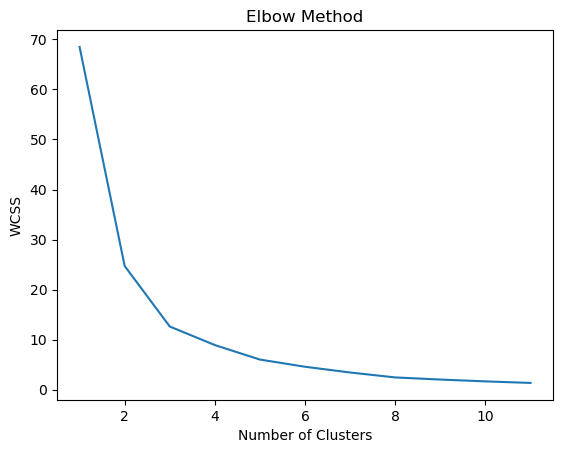

In [153]:
warnings.filterwarnings("ignore")
os.environ['OMP_NUM_THREADS'] = '2'

wcss = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Data)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(range(1, 12), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

# Sử dụng K - means để thực hiện phân cụm với số cụm mong muốn

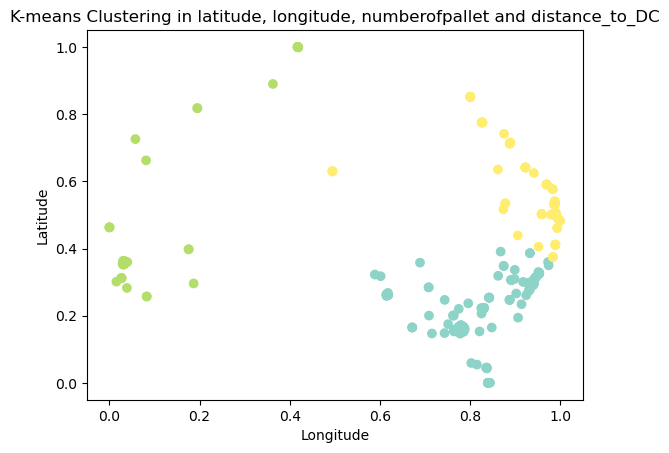

In [154]:
warnings.filterwarnings("ignore")
os.environ['OMP_NUM_THREADS'] = '2'

kmeans = KMeans(n_clusters=3)
kmeans.fit(Data)

labels = kmeans.labels_

color_map = plt.cm.get_cmap('Set3', len(np.unique(labels)))

# Vẽ biểu đồ
# Lấy giá trị trung tâm của từng cụm
cluster_centers = kmeans.cluster_centers_
# Vẽ biểu đồ các trung tâm cụm
plt.scatter(Data[:, 1], Data[:, 0], c=labels, cmap=color_map)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering in latitude, longitude, numberofpallet and distance_to_DC')
plt.show()

# Đưa các cluster vào ứng với mỗi khách hàng

In [155]:
TotalPalletPerCustomer['Cluster'] = labels
Data_to_Use = Data_to_Use.merge(TotalPalletPerCustomer[['CustomerRef', 'Cluster']], on='CustomerRef', how='left')
TotalPalletPerCustomer

,CustomerRef,PalletPerCustomer,Longitude,Latitude,DistanceToDC,Cluster
0,11000128,92.99,145.206237,-38.025962,0.488578,0
1,11000144,7.470929,144.947676,-37.728991,0.192579,0
2,11000149,6.678,152.519049,-32.197687,9.564369,0
3,11000159,0.342,153.122555,-27.617230,13.173460,2
4,11000176,3.466706,145.197119,-37.990926,0.465374,0
...,...,...,...,...,...,...
309,14021924,78.707143,153.118374,-27.445906,13.303771,2
310,14022011,33.661857,153.103894,-27.425455,13.310630,2
311,14022270,13.551214,144.371612,-38.054289,0.470621,0
312,14022376,6.96,147.383224,-35.121731,3.744891,0


## Task2

# Tạo df để tính toán dung tích cho từng điểm thu gom

In [156]:
Capacity_CP = Data_to_Use.loc[:,['SOCreationDate', 'PalletPerCustomer', 'Cluster']]
Capacity_CP

,SOCreationDate,PalletPerCustomer,Cluster
0,2021-08-02,57.705,0
1,2021-08-02,77.88,0
2,2021-08-02,13.5,0
3,2021-08-02,2.4,0
4,2021-08-02,7.2,0
...,...,...,...
28675,2022-12-31,12.0,0
28676,2022-12-31,8.4,0
28677,2022-12-31,32.4,0
28678,2022-12-31,15.6,0


## Lấy dữ liệu trong năm 2022, đồng thời tính số pallet được trả lại (theo cluster)

In [157]:
CapacityGrouped = Capacity_CP.groupby(['Cluster', 'SOCreationDate'])

Capacity_Grouped_Week_Cluster = CapacityGrouped['PalletPerCustomer'].sum().reset_index()
Capacity_Grouped_Week_Cluster = Capacity_Grouped_Week_Cluster[Capacity_Grouped_Week_Cluster['SOCreationDate'].dt.year == 2022].reset_index(drop = True)
Capacity_Grouped_Week_Cluster['Week'] = Capacity_Grouped_Week_Cluster['SOCreationDate'].dt.isocalendar().week
Capacity_Grouped_Week_Cluster['NumberOfPalletReturned'] = Capacity_Grouped_Week_Cluster['PalletPerCustomer'] / 2

Capacity_Grouped_Week_Cluster


,Cluster,SOCreationDate,PalletPerCustomer,Week,NumberOfPalletReturned
0,0,2022-01-01,152.4,52,76.2
1,0,2022-01-03,73.2,1,36.6
2,0,2022-01-04,618.070333,1,309.035167
3,0,2022-01-05,390.866087,1,195.433043
4,0,2022-01-06,441.722052,1,220.861026
...,...,...,...,...,...
839,2,2022-12-22,9.334857,51,4.667429
840,2,2022-12-23,7.485714,51,3.742857
841,2,2022-12-28,3.962857,52,1.981429
842,2,2022-12-29,7.022857,52,3.511429


### Tạo df riêng cho từng cluster

In [158]:
datafr_eachCluster = {}

for cluster in Capacity_Grouped_Week_Cluster['Cluster'].unique():
    datafr_eachCluster[cluster] = Capacity_Grouped_Week_Cluster[Capacity_Grouped_Week_Cluster['Cluster'] == cluster].reset_index()

# Hàm tính toán các chi phí

In [159]:
def costOverFlowPerWeek(numberOfWeek, Size, df):
    size = Size
    sumPallet = 0
    dateOverflow = 0
    totalCostOverFlowPerWeek = 0
    initOverflow = 0
    for i in range(df.shape[0]):
        if df['Week'][i] == numberOfWeek:
            if sumPallet < size:
                sumPallet += df['NumberOfPalletReturned'][i]
                if sumPallet > size:
                    dateOverflow = (df['SOCreationDate'][i].weekday() + 1)
                    initOverflow = (sumPallet - size) * 3
                    sumPallet = size
            else:
                sumPallet += df['NumberOfPalletReturned'][i]
    if sumPallet - size > 0:
        totalCostOverFlowPerWeek = initOverflow + (sumPallet - size) * 3 * (7 - dateOverflow)
        return totalCostOverFlowPerWeek
    else:
        return 0

def costOverflow(df, Size):
    cost = 0
    for week in range(1, 53):
        cost += costOverFlowPerWeek(week, Size, df)
    return cost   

def totalCost(df, Size):
    return Size * 100 + costOverflow(df, Size)

## Tính toán sức chứa của các cluster

In [160]:
sizeCluster = []

for cluster in range(3):
    costList = []
    sizeList = list(range(10, 1501, 10))
    for size in sizeList:
        costList.append(totalCost(datafr_eachCluster[cluster], size))
    sizeCluster.append(sizeList[costList.index(min(costList))])
sizeCluster

[1370, 20, 40]

### Lấy lại giá trị trước khi chuẩn hóa

In [161]:
Restored_data = scaler.inverse_transform(cluster_centers)
Restored_data

array([[ -35.90973629,  146.72744591,    4.55093871, 1126.23369324],
       [ -28.09866974,  118.81835977,   29.15875963,   57.32476087],
       [ -25.56228412,  150.79286829,   14.43940781,   63.55363485]])

# Vị trí, kích thước của từng cluster

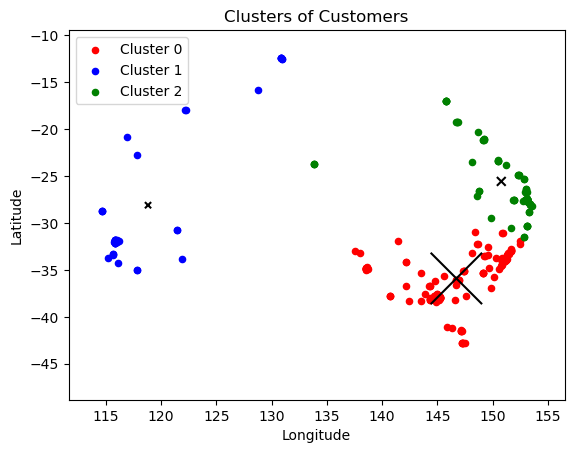

In [162]:
# Cụm 0
Longitude_0 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 0]['Longitude']
Latitude_0 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 0]['Latitude']
plt.scatter(Longitude_0, Latitude_0, s=20, c='red', label='Cluster 0')

#Cụm 1
Longitude_1 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 1]['Longitude']
Latitude_1 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 1]['Latitude']
plt.scatter(Longitude_1, Latitude_1, s=20, c='blue', label='Cluster 1')

#Cụm 2
Longitude_2 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 2]['Longitude']
Latitude_2 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 2]['Latitude']
plt.scatter(Longitude_2, Latitude_2, s=20, c='greeN', label='Cluster 2')

# Đặt giới hạn cho trục x và y
plt.xlim(Customer_Master['Longitude'].min() - 3, Customer_Master['Longitude'].max()+ 3) 
plt.ylim(Customer_Master['Latitude'].min() - 6, Customer_Master['Latitude'].max()+ 3) 
plt.scatter(Restored_data[:, 1], Restored_data[:, 0], s=sizeCluster, marker='x', color='Black')

# Đặt tiêu đề và chú thích
plt.title('Clusters of Customers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Hiển thị biểu đồ chung
plt.show()

In [163]:
cost_cluster_11 = pd.concat([datafr_eachCluster[1]], axis=0, ignore_index=True)
cost_cluster_21 = pd.concat([datafr_eachCluster[2]], axis=0, ignore_index=True)
cost_cluster_01 = pd.concat([datafr_eachCluster[0]], axis=0, ignore_index=True)
print("Cluster 1:", totalCost(cost_cluster_01, 1400))
print("Cluster 2:", totalCost(cost_cluster_21, 70))
print("Cluster 0: ", totalCost(cost_cluster_11, 70))

total1 = totalCost(cost_cluster_01, 1400) + totalCost(cost_cluster_21, 70) + totalCost(cost_cluster_11, 70)
annual1 = 140000 + 7000 + 7000
print("Total Cost: ",total1)
print("Annual Cost:", annual1)

Cluster 1: 146714.09174675526
Cluster 2: 7000
Cluster 0:  7000
Total Cost:  160714.09174675526
Annual Cost: 154000


Với 3 cụm này, t thấy chi phí tổng là hơn 160 ngàn $, chi phí cũng tương đối, phí thường niên tương đối cao
Ta sẽ thử tiến hành tách cluster 0 thành 2 để xem chi phí như thế nào.

## Thực hiện tách cluster 0

In [164]:
cluster_0  = TotalPalletPerCustomer[(TotalPalletPerCustomer['Cluster'] == 0 )]

In [165]:
# Các cột xác định cần chuẩn hóa
Columns_to_Normalize = ['Latitude', 'Longitude', 'DistanceToDC', 'PalletPerCustomer']
scaler = MinMaxScaler()
df_normalized_cluster_0 = cluster_0.copy()
df_normalized_cluster_0[Columns_to_Normalize] = scaler.fit_transform(cluster_0[Columns_to_Normalize])
df_normalized_cluster_0

,CustomerRef,PalletPerCustomer,Longitude,Latitude,DistanceToDC,Cluster
0,11000128,0.000616,0.512116,0.405315,0.048164,0
1,11000144,0.000049,0.494866,0.430298,0.017589,0
2,11000149,0.000044,1.000000,0.895628,0.985621,0
4,11000176,0.000023,0.511508,0.408263,0.045767,0
7,11000197,0.000113,0.489628,0.431837,0.011767,0
...,...,...,...,...,...,...
305,14021494,0.000043,0.650149,0.001319,0.577498,0
306,14021496,0.000431,0.888573,0.743527,0.738080,0
307,14021687,0.000003,0.077341,0.669951,0.694691,0
311,14022270,0.000089,0.456433,0.402932,0.046309,0


In [166]:
# Dữ liệu vĩ độ và kinh độ
Longitude = df_normalized_cluster_0['Longitude']
Latitude = df_normalized_cluster_0['Latitude']
DistanceToDC = df_normalized_cluster_0['DistanceToDC']

# Ghép hai features thành một mảng 2D
Data = np.column_stack((Latitude, Longitude, DistanceToDC))

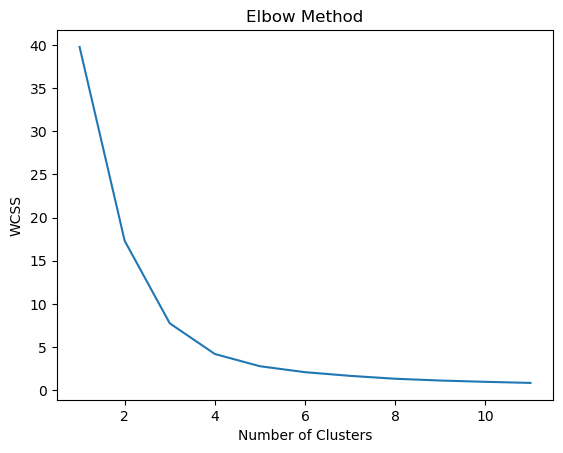

In [167]:
warnings.filterwarnings("ignore")
os.environ['OMP_NUM_THREADS'] = '2'

wcss = []
for k in range(1, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Data)
    wcss.append(kmeans.inertia_)

# Plot the WCSS values against the number of clusters
plt.plot(range(1, 12), wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

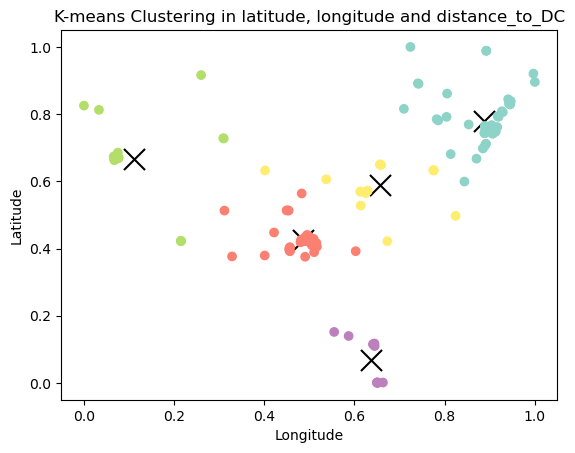

In [168]:

warnings.filterwarnings("ignore")
os.environ['OMP_NUM_THREADS'] = '2'

# Áp dụng KMeans với số lượng cụm mong muốn
kmeans = KMeans(n_clusters=5)
kmeans.fit(Data)
# Lấy nhãn của các điểm dữ liệu
labels = kmeans.labels_

# Tạo bảng màu cho các nhãn
color_map = plt.cm.get_cmap('Set3', len(np.unique(labels)))

# Vẽ biểu đồ
# Lấy giá trị trung tâm của từng cụm
cluster_centers = kmeans.cluster_centers_
# Vẽ biểu đồ các trung tâm cụm
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], marker='x', s=230, color='black')
plt.scatter(Data[:, 1], Data[:, 0], c=labels, cmap=color_map)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering in latitude, longitude and distance_to_DC')
plt.show()

In [169]:
labels = kmeans.labels_
df_normalized_cluster_0['SubCluster'] = labels
df_normalized_cluster_0

,CustomerRef,PalletPerCustomer,Longitude,Latitude,DistanceToDC,Cluster,SubCluster
0,11000128,0.000616,0.512116,0.405315,0.048164,0,1
1,11000144,0.000049,0.494866,0.430298,0.017589,0,1
2,11000149,0.000044,1.000000,0.895628,0.985621,0,0
4,11000176,0.000023,0.511508,0.408263,0.045767,0,1
7,11000197,0.000113,0.489628,0.431837,0.011767,0,1
...,...,...,...,...,...,...,...
305,14021494,0.000043,0.650149,0.001319,0.577498,0,3
306,14021496,0.000431,0.888573,0.743527,0.738080,0,0
307,14021687,0.000003,0.077341,0.669951,0.694691,0,2
311,14022270,0.000089,0.456433,0.402932,0.046309,0,1


In [170]:
CustomerRef_to_SubCluster = dict(zip(df_normalized_cluster_0['CustomerRef'], df_normalized_cluster_0['SubCluster']))
Data_to_Use['SubCluster'] = Data_to_Use['CustomerRef'].map(CustomerRef_to_SubCluster)
TotalPalletPerCustomer['SubCluster'] = TotalPalletPerCustomer['CustomerRef'].map(CustomerRef_to_SubCluster)
Data_to_Use.head()

,ProductID,CustomerRef,SOCreationDate,DispatchQuantityInKg,NetWeightInKg,GrossWeightInKg,ProductName,KgPerPallet,Unit,CartonsPerPallet,UnitperCarton,Longitude,Latitude,PalletPerCustomer,No_OfUnit,Cluster,SubCluster
0,3110685,14019842,2021-08-02,57224.8944,57224.8944,58697.5260,OW MLK WHOLE 6X2L BOT,991.68,GBOT,80.0,6,144.763895,-37.831035,57.705,27698.4,0,1.0
1,3110678,14019842,2021-08-02,77232.0384,77232.0384,79387.7568,OW MLK WHOLE 4x3L BOT,991.68,GBOT,80.0,4,144.763895,-37.831035,77.88,24921.6,0,1.0
2,3103449,14019842,2021-08-02,13387.6800,13387.6800,13732.2000,OW FRMRS OWN MLK FL CRM 6X2L BOT,991.68,GBOT,80.0,6,144.763895,-37.831035,13.5,6480.0,0,1.0
3,3103450,14019842,2021-08-02,2380.0320,2380.0320,2446.4640,OW FRMRS OWN MLK FL CRM 4X3L BOT,991.68,GBOT,80.0,4,144.763895,-37.831035,2.4,768.0,0,1.0
4,3110656,11002626,2021-08-02,7147.0080,7147.0080,7330.7520,OW MLK LITE 6X2L BOT,992.64,GBOT,80,6,146.721094,-36.076072,7.2,3456.0,0,4.0


In [171]:
dfCapacity_sub_cluster_0 = Data_to_Use.loc[:, ['SOCreationDate', 'PalletPerCustomer', 'SubCluster']]
dfCapacity_sub_cluster_0

,SOCreationDate,PalletPerCustomer,SubCluster
0,2021-08-02,57.705,1.0
1,2021-08-02,77.88,1.0
2,2021-08-02,13.5,1.0
3,2021-08-02,2.4,1.0
4,2021-08-02,7.2,4.0
...,...,...,...
28675,2022-12-31,12.0,4.0
28676,2022-12-31,8.4,4.0
28677,2022-12-31,32.4,4.0
28678,2022-12-31,15.6,4.0


In [174]:
CapacitySubClusterGrouped = dfCapacity_sub_cluster_0.groupby(['SubCluster', 'SOCreationDate'])['PalletPerCustomer'].sum().reset_index()

CapacitySubClusterGrouped = CapacitySubClusterGrouped[CapacitySubClusterGrouped['SOCreationDate'].dt.year == 2022].reset_index(drop=True)
CapacitySubClusterGrouped['Week'] = CapacitySubClusterGrouped['SOCreationDate'].dt.isocalendar().week
CapacitySubClusterGrouped['NumberOfPalletReturned'] = CapacitySubClusterGrouped['PalletPerCustomer'] / 2

CapacitySubClusterGrouped


,SubCluster,SOCreationDate,PalletPerCustomer,Week,NumberOfPalletReturned
0,0.0,2022-01-04,12.8065,1,6.40325
1,0.0,2022-01-05,1.176381,1,0.58819
2,0.0,2022-01-06,2.442376,1,1.221188
3,0.0,2022-01-07,13.424,1,6.712
4,0.0,2022-01-10,8.231,2,4.1155
...,...,...,...,...,...
1305,4.0,2022-12-27,0.06,52,0.03
1306,4.0,2022-12-28,96.538857,52,48.269429
1307,4.0,2022-12-29,72.0,52,36.0
1308,4.0,2022-12-30,53.162286,52,26.581143


In [175]:
subclusters = [0, 1, 2, 3, 4]
dfCapacityGroupedSubClusters = {}

for subcluster in subclusters:
    dfCapacityGroupedSubClusters[subcluster] = CapacitySubClusterGrouped[CapacitySubClusterGrouped['SubCluster'] == subcluster].reset_index(drop=True)

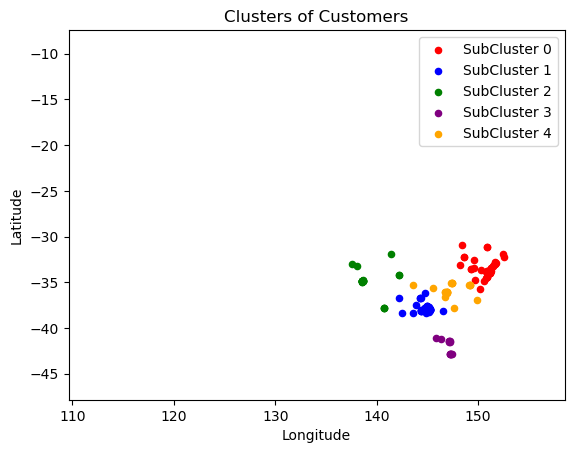

In [176]:
# Cụm 0
Longitude_0 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 0]['Longitude']
Latitude_0 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 0]['Latitude']
plt.scatter(Longitude_0, Latitude_0, s=20, c='red', label='SubCluster 0')

# Cụm 1
Longitude_1 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 1]['Longitude']
Latitude_1 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 1]['Latitude']
plt.scatter(Longitude_1, Latitude_1, s=20, c='blue', label='SubCluster 1')

# Cụm 2
Longitude_2 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 2]['Longitude']
Latitude_2 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 2]['Latitude']
plt.scatter(Longitude_2, Latitude_2, s=20, c='green', label='SubCluster 2')

# Cụm 3
Longitude_3 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 3]['Longitude']
Latitude_3 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 3]['Latitude']
plt.scatter(Longitude_3, Latitude_3, s=20, c='purple', label='SubCluster 3')

# Cụm 4
Longitude_4 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 4]['Longitude']
Latitude_4 = TotalPalletPerCustomer[TotalPalletPerCustomer['SubCluster'] == 4]['Latitude']
plt.scatter(Longitude_4, Latitude_4, s=20, c='orange', label='SubCluster 4')

# Đặt giới hạn cho trục x và y
plt.xlim(Customer_Master['Longitude'].min() - 5, Customer_Master['Longitude'].max()+ 5) 
plt.ylim(Customer_Master['Latitude'].min() - 5, Customer_Master['Latitude'].max()+ 5) 

# Đặt tiêu đề và chú thích
plt.title('Clusters of Customers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Hiển thị biểu đồ chung
plt.show()

## Biểu đồ thể hiện số pallet trả lại hàng tuần của mỗi Cụm trong 1 năm 

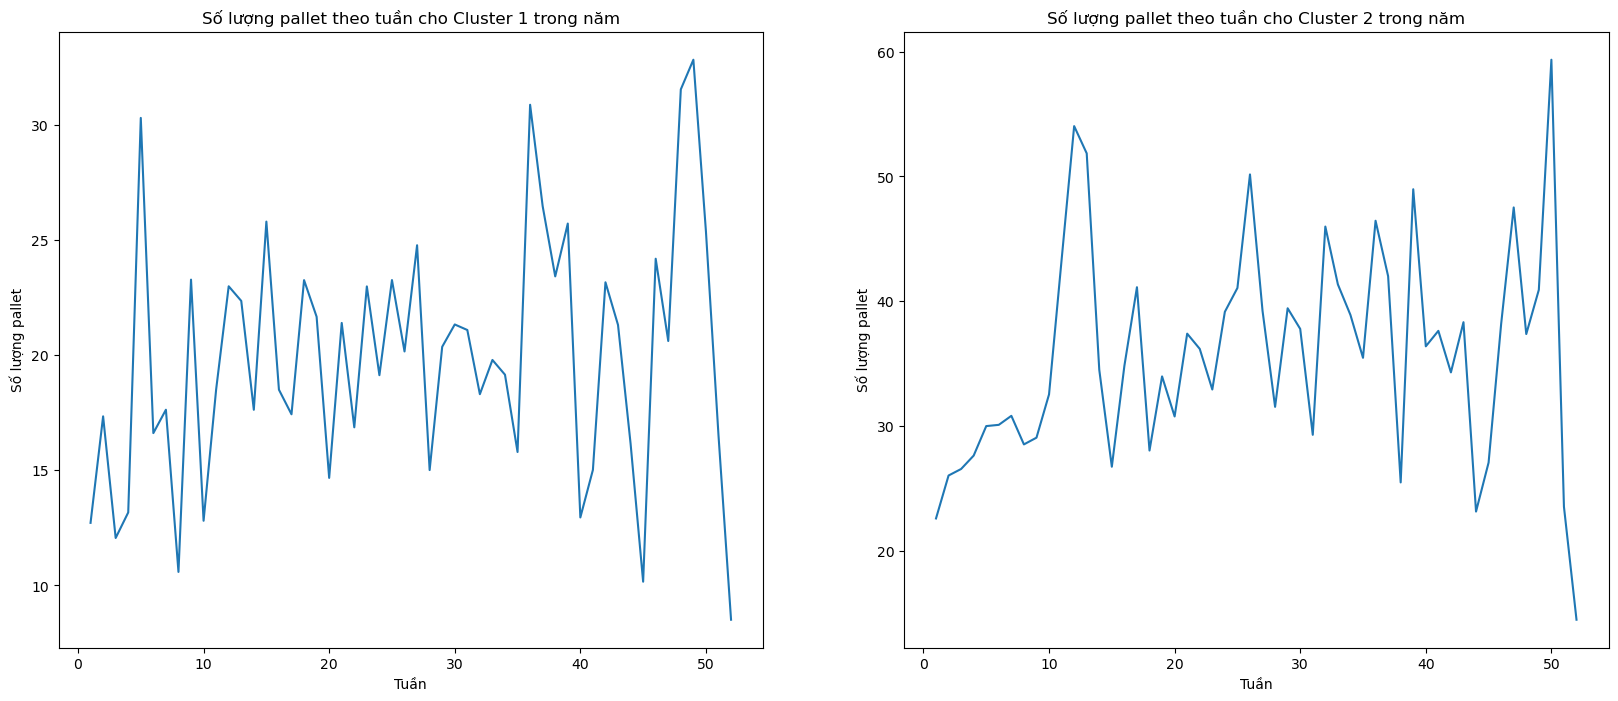

In [177]:
# Khởi tạo figure
plt.figure(figsize=(20, 8))  # Đặt kích thước cho cả hai biểu đồ

# Vẽ biểu đồ cho Cluster 1
Cluster_data1 = Capacity_Grouped_Week_Cluster[Capacity_Grouped_Week_Cluster['Cluster'] == 1]
Weekly_pallet_Cluster1 = Cluster_data1.groupby('Week')['NumberOfPalletReturned'].sum()
plt.subplot(1, 2, 1)  # Chọn subplot đầu tiên
plt.plot(Weekly_pallet_Cluster1.index, Weekly_pallet_Cluster1.values, linestyle='-')
plt.title(f'Số lượng pallet theo tuần cho Cluster 1 trong năm')
plt.xlabel('Tuần')
plt.ylabel('Số lượng pallet')

# Vẽ biểu đồ cho Cluster 2
Cluster_data2 = Capacity_Grouped_Week_Cluster[Capacity_Grouped_Week_Cluster['Cluster'] == 2]
Weekly_pallet_Cluster2 = Cluster_data2.groupby('Week')['NumberOfPalletReturned'].sum()
plt.subplot(1, 2, 2)  # Chọn subplot thứ hai
plt.plot(Weekly_pallet_Cluster2.index, Weekly_pallet_Cluster2.values, linestyle='-')
plt.title(f'Số lượng pallet theo tuần cho Cluster 2 trong năm')
plt.xlabel('Tuần')
plt.ylabel('Số lượng pallet')

# Hiển thị biểu đồ
plt.show()


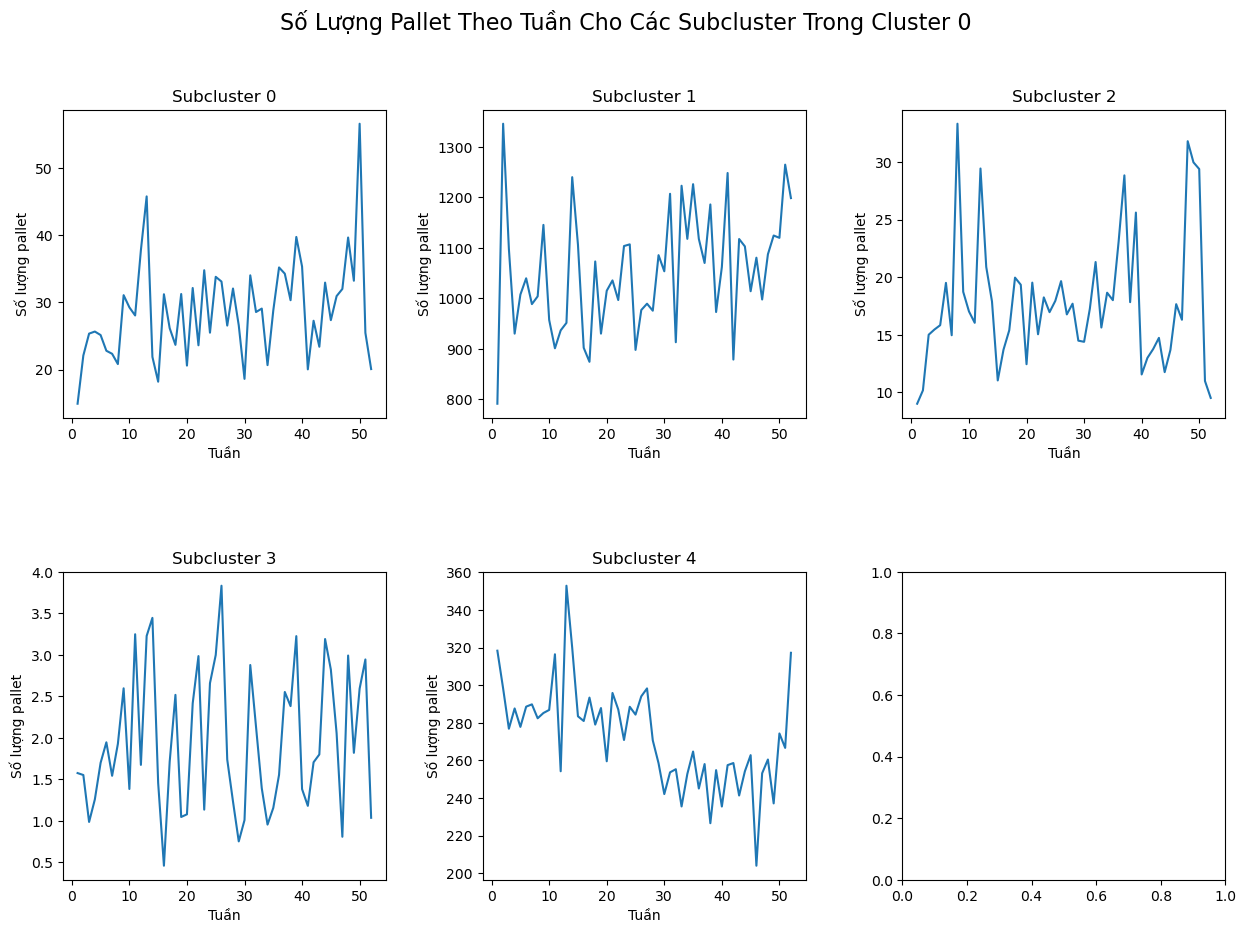

In [178]:
# Khởi tạo subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))  # Đặt kích thước tổng thể cho cả năm biểu đồ
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Điều chỉnh khoảng cách giữa các biểu đồ

fig.suptitle('Số Lượng Pallet Theo Tuần Cho Các Subcluster Trong Cluster 0', fontsize=16)

# Vẽ biểu đồ cho từng SubCluster trong Cluster 0
for i in range(5):
    cluster_data0 = CapacitySubClusterGrouped[(CapacitySubClusterGrouped['SubCluster'] == i)]
    Weekly_pallet_Cluster0 = cluster_data0.groupby('Week')['NumberOfPalletReturned'].sum()
    
    # Chọn vị trí subplot phù hợp
    if i < 3:
        ax = axs[0, i]
    else:
        ax = axs[1, i - 3]
    
    ax.plot(Weekly_pallet_Cluster0.index, Weekly_pallet_Cluster0.values, linestyle='-')
    ax.set_title(f'Subcluster {i}')
    ax.set_xlabel('Tuần')
    ax.set_ylabel('Số lượng pallet')

# Hiển thị biểu đồ
plt.show()


### Tính số lượng pallet trung bình mỗi tuần để thiết lập kích thước điểm thu gom

In [179]:
sizeSubCluster = []

for cluster in range(5):
    costList = []
    sizeList = list(range(1, 50, 1))
    for size in sizeList:
        costList.append(totalCost(dfCapacityGroupedSubClusters[cluster], size))
    sizeSubCluster.append(sizeList[costList.index(min(costList))])
sizeSubCluster

[28, 49, 17, 3, 49]

In [180]:
costList = []
sizeList = list(range(800, 1301, 10))
for size in sizeList:
    costList.append(totalCost(dfCapacityGroupedSubClusters[1], size))
sizeSubCluster.append(sizeList[costList.index(min(costList))])
sizeSubCluster


[28, 49, 17, 3, 49, 960]

In [181]:
costList = []
sizeList = list(range(100, 500, 10))
for size in sizeList:
    costList.append(totalCost(dfCapacityGroupedSubClusters[4], size))
sizeSubCluster.append(sizeList[costList.index(min(costList))])
sizeSubCluster

[28, 49, 17, 3, 49, 960, 250]

In [182]:
sizeSubCluster = [28, 960, 17, 3, 250]

Ta thấy subCluster 1 và 4 chứa số lượng pallet trả về rất lớn. Ta có thể chọn vị trí của điểm thu gom là vị trí của các khách hàng ở đây

Subcluster 2, 3 ta sẽ gộp chung với subcluster 1

Subcluster 0 có số lượng không đáng kể, ta có thể gộp chung với subcluster 4

Vậy: subcluster 1 sẽ có 4 điểm thu gom size medium, 1 điểm thu gom size small
     
     subcluster 4 sẽ có 4 điểm thu gom size small

In [183]:
TotalPalletPerCustomer.iloc[295]
longitude_cluster_0_1_center = TotalPalletPerCustomer.iloc[295]['Longitude']
latitude_cluster_0_1_center = TotalPalletPerCustomer.iloc[295]['Latitude']
TotalPalletPerCustomer.iloc[191]
longitude_cluster_0_4_center = TotalPalletPerCustomer.iloc[191]['Longitude']
latitude_cluster_0_4_center = TotalPalletPerCustomer.iloc[191]['Latitude']

In [184]:
Restored_data

array([[ -35.90973629,  146.72744591,    4.55093871, 1126.23369324],
       [ -28.09866974,  118.81835977,   29.15875963,   57.32476087],
       [ -25.56228412,  150.79286829,   14.43940781,   63.55363485]])

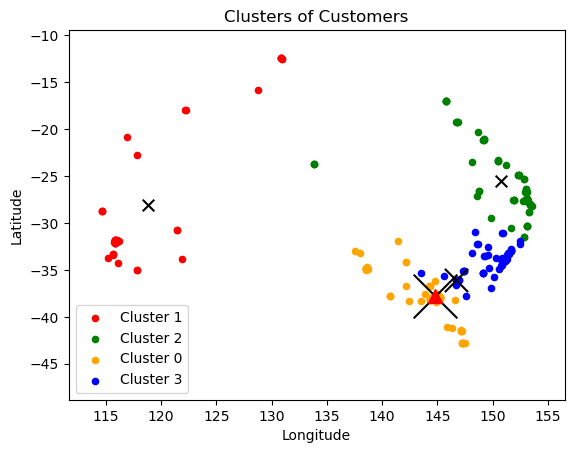

In [185]:
# Cụm 1
Longitude_1 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 1]['Longitude']
Latitude_1 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 1]['Latitude']
plt.scatter(Longitude_1, Latitude_1, s=20, c='red', label='Cluster 1')

#Cụm 2
Longitude_2 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 2]['Longitude']
Latitude_2 = TotalPalletPerCustomer[TotalPalletPerCustomer['Cluster'] == 2]['Latitude']
plt.scatter(Longitude_2, Latitude_2, s=20, c='greeN', label='Cluster 2')

#Cụm 0_0
Longitude_0 = TotalPalletPerCustomer[(TotalPalletPerCustomer['SubCluster'] == 2) | (TotalPalletPerCustomer['SubCluster'] == 3) | (TotalPalletPerCustomer['SubCluster'] == 1)]['Longitude']
Latitude_0 = TotalPalletPerCustomer[(TotalPalletPerCustomer['SubCluster'] == 2) | (TotalPalletPerCustomer['SubCluster'] == 3) | (TotalPalletPerCustomer['SubCluster'] == 1)]['Latitude']
plt.scatter(Longitude_0, Latitude_0, s=20, c='orange', label='Cluster 0')
                                    
#Cụm 0_2
Longitude_0 = TotalPalletPerCustomer[(TotalPalletPerCustomer['SubCluster'] == 0) | (TotalPalletPerCustomer['SubCluster'] == 4)]['Longitude']
Latitude_0 = TotalPalletPerCustomer[(TotalPalletPerCustomer['SubCluster'] == 0) | (TotalPalletPerCustomer['SubCluster'] == 4)]['Latitude']
plt.scatter(Longitude_0, Latitude_0, s=20, c='blue', label='Cluster 3')

# Đặt giới hạn cho trục x và y
plt.xlim(Customer_Master['Longitude'].min() - 3, Customer_Master['Longitude'].max() + 3)
plt.ylim(Customer_Master['Latitude'].min() - 6, Customer_Master['Latitude'].max() + 3)

# Plot cluster centers
plt.scatter(Restored_data[1,1], Restored_data[1,0], s=70, marker='x', color='black')
plt.scatter(Restored_data[2,1], Restored_data[2,0], s=70, marker='x', color='black')
plt.scatter(longitude_cluster_0_1_center, latitude_cluster_0_1_center, s=990, marker='x', color='black')
plt.scatter(longitude_cluster_0_4_center, latitude_cluster_0_4_center, s=280, marker='x', color='black')
plt.scatter(DC_Longitude, DC_Latitude, s = 100, marker = '^', color = 'red')

# Đặt tiêu đề và chú thích
plt.title('Clusters of Customers')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Hiển thị biểu đồ chung
plt.show()

In [189]:
cost_cluster_1 = pd.concat([datafr_eachCluster[1]], axis=0, ignore_index=True)
cost_cluster_2 = pd.concat([datafr_eachCluster[2]], axis=0, ignore_index=True)
cost_cluster_0_1 = pd.concat([dfCapacityGroupedSubClusters[1], dfCapacityGroupedSubClusters[2],dfCapacityGroupedSubClusters[3]], axis=0, ignore_index=True)
cost_cluster_0_4 = pd.concat([dfCapacityGroupedSubClusters[0], dfCapacityGroupedSubClusters[4]], axis = 0, ignore_index=True)

#Total_cost = totalCost(cost_cluster_1, 70) + totalCost(cost_cluster_2, 70) + totalCost(cost_cluster_0_0, 990) + totalCost(cost_cluster_0_2, 280)
#Overflow_Cost = (totalCost(cost_cluster_0_0, 990) - 99000) + (totalCost(cost_cluster_0_2, 280) - 28000)

print("Cluster 0: ", totalCost(cost_cluster_0_1, 990))
print("Cluster 1:", totalCost(cost_cluster_1, 70))
print("Cluster 2:", totalCost(cost_cluster_2, 70))
print("Cluster 3: ", totalCost(cost_cluster_0_4, 280))


Cluster 0:  117101.94542039366
Cluster 1: 7000
Cluster 2: 7000
Cluster 3:  29289.73626776273


In [190]:
Total_cost = totalCost(cost_cluster_1, 70) + totalCost(cost_cluster_2, 70) + totalCost(cost_cluster_0_1, 990) + totalCost(cost_cluster_0_4, 280)
Overflow_Cost = (totalCost(cost_cluster_0_1, 990) - 99000) + (totalCost(cost_cluster_0_4, 280) - 28000)

print("Total Cost: ", Total_cost)
print("Overflow Cost: ", Overflow_Cost)
print("Annual Cost: ", Total_cost - Overflow_Cost)
print("%Overflow: ", Overflow_Cost/(Total_cost)*100)

Total Cost:  160391.6816881564
Overflow Cost:  19391.681688156394
Annual Cost:  141000.0
%Overflow:  12.09020410787819


# Tính toán GHG, tỉ lệ Circular Inflow

In [191]:
Data_to_Use = Data_to_Use[Data_to_Use['SOCreationDate'].dt.year == 2022].reset_index(drop = True)
Data_to_Use['PackagingWeightInKg'] = Data_to_Use['GrossWeightInKg'] - Data_to_Use['NetWeightInKg']
Data_to_Use

,ProductID,CustomerRef,SOCreationDate,DispatchQuantityInKg,NetWeightInKg,GrossWeightInKg,ProductName,KgPerPallet,Unit,CartonsPerPallet,UnitperCarton,Longitude,Latitude,PalletPerCustomer,No_OfUnit,Cluster,SubCluster,PackagingWeightInKg
0,3110656,11002626,2022-01-01,9529.344,9529.344,9774.336,OW MLK LITE 6X2L BOT,992.64,GBOT,80,6,146.721094,-36.076072,9.6,4608.0,0,4.0,244.992
1,3110678,11002626,2022-01-01,36890.496,36890.496,37920.192,OW MLK WHOLE 4x3L BOT,991.68,GBOT,80.0,4,146.721094,-36.076072,37.2,11904.0,0,4.0,1029.696
2,3110685,11002626,2022-01-01,19040.256,19040.256,19530.240,OW MLK WHOLE 6X2L BOT,991.68,GBOT,80.0,6,146.721094,-36.076072,19.2,9216.0,0,4.0,489.984
3,3110687,11002626,2022-01-01,13102.848,13102.848,13468.224,OW MLK LITE 4x3L BOT,992.64,GBOT,80,4,146.721094,-36.076072,13.2,4224.0,0,4.0,365.376
4,3110656,11002626,2022-01-01,8338.176,8338.176,8552.544,OW MLK LITE 6X2L BOT,992.64,GBOT,80,6,146.721094,-36.076072,8.4,4032.0,0,4.0,214.368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20369,3110687,11002626,2022-12-31,11911.680,11911.680,12243.840,OW MLK LITE 4x3L BOT,992.64,GBOT,80,4,146.721094,-36.076072,12.0,3840.0,0,4.0,332.160
20370,3110656,11002626,2022-12-31,8338.176,8338.176,8552.544,OW MLK LITE 6X2L BOT,992.64,GBOT,80,6,146.721094,-36.076072,8.4,4032.0,0,4.0,214.368
20371,3110678,11002626,2022-12-31,32130.432,32130.432,33027.264,OW MLK WHOLE 4x3L BOT,991.68,GBOT,80.0,4,146.721094,-36.076072,32.4,10368.0,0,4.0,896.832
20372,3110685,11002626,2022-12-31,15470.208,15470.208,15868.320,OW MLK WHOLE 6X2L BOT,991.68,GBOT,80.0,6,146.721094,-36.076072,15.6,7488.0,0,4.0,398.112


## Tính tổng khối lượng vỏ theo loại sản phẩm

In [192]:
PackageGrouped = Data_to_Use.groupby('Unit')
dfPackageGrouped =PackageGrouped['PackagingWeightInKg'].sum()
dfPackageGrouped = dfPackageGrouped.reset_index()
dfPackageGrouped['PackagingWeightReturned'] = dfPackageGrouped['PackagingWeightInKg']/2
dfPackageGrouped

,Unit,PackagingWeightInKg,PackagingWeightReturned
0,CTN,5.156046e+05,2.578023e+05
1,GBOT,3.458379e+06,1.729190e+06
2,PBOT,3.988095e+05,1.994048e+05


In [193]:
Capacity_Grouped_Week_Cluster['Weekday'] = Capacity_Grouped_Week_Cluster['SOCreationDate'].dt.weekday #thứ mấy trong tuần (thứ 2 thì là 0)
Capacity_Grouped_Week_Cluster['DayInCollectionPoint'] = 6 - Capacity_Grouped_Week_Cluster['Weekday'] 
Capacity_Grouped_Week_Cluster

,Cluster,SOCreationDate,PalletPerCustomer,Week,NumberOfPalletReturned,Weekday,DayInCollectionPoint
0,0,2022-01-01,152.4,52,76.2,5,1
1,0,2022-01-03,73.2,1,36.6,0,6
2,0,2022-01-04,618.070333,1,309.035167,1,5
3,0,2022-01-05,390.866087,1,195.433043,2,4
4,0,2022-01-06,441.722052,1,220.861026,3,3
...,...,...,...,...,...,...,...
839,2,2022-12-22,9.334857,51,4.667429,3,3
840,2,2022-12-23,7.485714,51,3.742857,4,2
841,2,2022-12-28,3.962857,52,1.981429,2,4
842,2,2022-12-29,7.022857,52,3.511429,3,3


In [194]:
CO2_cause_by_collection_point = Capacity_Grouped_Week_Cluster['NumberOfPalletReturned'] * Capacity_Grouped_Week_Cluster['DayInCollectionPoint'] * 2.4 * 0.371/365 * 1000
CO2_cause_by_collection_point.sum()

659228.1123774828

## CO2 khi chưa áp dụng tái chế

In [195]:
CO2_not_Recycled_Virgin_content = dfPackageGrouped.iloc[0, 1]*0.7*0.95 + dfPackageGrouped.iloc[1, 1]*1.2 + dfPackageGrouped.iloc[2, 1] * 3.1 * 0.9
CO2_not_Recycled_Recycled_content = dfPackageGrouped.iloc[0, 1]*0.57*0.05  + dfPackageGrouped.iloc[2, 1] * 1.7 * 0.1
CO2_not_Recycled = CO2_not_Recycled_Virgin_content + CO2_not_Recycled_Recycled_content
CO2_not_Recycled

5688102.905339997

## CO2 thải ra của từng loại vật liệu trước tái chế

In [196]:
print(dfPackageGrouped.iloc[0, 1]*0.7*0.95 + dfPackageGrouped.iloc[0, 1]*0.57*0.05)
print(dfPackageGrouped.iloc[2, 1] * 3.1 * 0.9 + dfPackageGrouped.iloc[2, 1] * 1.7 * 0.1)
print(dfPackageGrouped.iloc[1, 1]*1.2)

357571.82338799967
1180476.2301120001
4150054.851839998


## CO2 Sau khi áp dụng tái chế

In [197]:
CO2_After_Implement_Plan_Virgin = dfPackageGrouped.iloc[0, 1]*0.7*0.3 + dfPackageGrouped.iloc[2, 1] * 3.1 * 0.3
CO2_After_Implement_Plan_Recycled = dfPackageGrouped.iloc[0, 1]*0.57*0.7 + dfPackageGrouped.iloc[1, 1]*0.55 + dfPackageGrouped.iloc[2, 1] * 1.7 * 0.7

CO2_After_Implement_Plan = CO2_After_Implement_Plan_Virgin + CO2_After_Implement_Plan_Recycled
CO2_After_Implement_Plan

3061587.9232559996

## CO2 của từng loại vật liệu sau khi tái chế

In [198]:
print(dfPackageGrouped.iloc[0, 1]*0.7*0.3 + dfPackageGrouped.iloc[0, 1]*0.57*0.7)
print(dfPackageGrouped.iloc[2, 1] * 3.1 * 0.3 + dfPackageGrouped.iloc[2, 1] * 1.7 * 0.7)
print(dfPackageGrouped.iloc[1, 1]*0.55)

314003.23063199973
845476.218864
1902108.4737599993


## CO2 giảm được sau khi tái chế

In [199]:
CO2_Reduce = CO2_not_Recycled - CO2_After_Implement_Plan - CO2_cause_by_collection_point.sum()
CO2_Reduce

1967286.8697065148

## Tỉ lệ Circular Inflow

In [200]:
Circular_inflow = (0.7 * dfPackageGrouped.iloc[2,1] + 0.7 * dfPackageGrouped.iloc[0,1] + dfPackageGrouped.iloc[1,1])

Circular_inflow = Circular_inflow / (dfPackageGrouped.iloc[0,1] + dfPackageGrouped.iloc[1,1] + dfPackageGrouped.iloc[2,1])
Circular_inflow

0.9372656695088292